In [1]:
import os
import gc
import cv2
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False
import keras
import keras.backend as K
from keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Input, Lambda, Flatten, Dense
from keras.models import *
from keras import optimizers
from keras.layers.merge import concatenate
from keras.callbacks import *

Using TensorFlow backend.
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
#Grab training data

In [2]:
left_link = './sign_validate/ReTrai/'
right_link = './sign_validate/RePhai/'
other_link = './sign_validate/Other/'

In [4]:
X_data = []
y_true = []
for left in os.listdir(left_link):
    img = cv2.imread(left_link + left)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_data.append(img)
    y_true.append([0.0, 0.0, 1.0])
    
for right in os.listdir(right_link):
    img = cv2.imread(right_link + right)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_data.append(img)
    y_true.append([0.0, 1.0, 0.0])
    
for other in os.listdir(other_link):
    img = cv2.imread(other_link + other)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_data.append(img)
    y_true.append([1.0, 0.0, 0.0])
    
X_test = np.array(X_data)
y_test = np.array(y_true)
print(X_test.shape)
print(y_test.shape)

(44, 64, 64, 3)
(44, 3)


In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_true)

In [6]:
# print(X_train.shape)
# print(X_test.shape)

In [37]:
model = Sequential()

model.add(Conv2D(16, 3, activation = 'relu', input_shape= (64, 64, 3)))
model.add(MaxPool2D((2, 2), (2, 2)))
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(MaxPool2D((2, 2), (2, 2)))
model.add(Conv2D(64, 3, activation = 'relu'))
model.add(MaxPool2D((2, 2), (2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

In [27]:
adam = optimizers.Adam(0.0001, 0.9, 0.99)
model.compile(adam, 'categorical_crossentropy', ['accuracy'])

In [28]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=0.0001)

In [29]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10)

In [30]:
train_datagen = train_datagen.flow_from_directory('./sign/', (64, 64), class_mode='categorical', batch_size=16, color_mode='rgb')

Found 630 images belonging to 3 classes.


[0. 1. 0.]


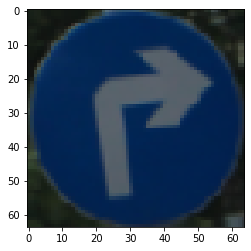

In [14]:
n = train_datagen.next()
X = n[0][0]
y = n[1][0]
# plt.imshow(X.astype('int'))
plt.imshow(X.astype('int'))
print(y)

In [31]:
history = model.fit_generator(train_datagen, 100, 150, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/150
100/100 [==============================] - 2s 23ms/step - loss: 2.8243 - accuracy: 0.7497 - val_loss: 0.7182 - val_accuracy: 0.7500
Epoch 2/150
100/100 [==============================] - 2s 23ms/step - loss: 0.3193 - accuracy: 0.9133 - val_loss: 0.5700 - val_accuracy: 0.8409
Epoch 3/150
100/100 [==============================] - 2s 24ms/step - loss: 0.2659 - accuracy: 0.9114 - val_loss: 0.7586 - val_accuracy: 0.5909
Epoch 4/150
100/100 [==============================] - 2s 23ms/step - loss: 0.2024 - accuracy: 0.9344 - val_loss: 0.5842 - val_accuracy: 0.8182
Epoch 5/150
100/100 [==============================] - 2s 24ms/step - loss: 0.1716 - accuracy: 0.9373 - val_loss: 0.5321 - val_accuracy: 0.8409
Epoch 6/150
100/100 [==============================] - 2s 23ms/step - loss: 0.1100 - accuracy: 0.9605 - val_loss: 0.6716 - val_accuracy: 0.7727
Epoch 7/150
100/100 [==============================] - 2s 24ms/step - loss: 0.1118 - accuracy: 0.9561 - val_loss: 0.4579 - val_accuracy:

100/100 [==============================] - 2s 24ms/step - loss: 1.2232e-04 - accuracy: 1.0000 - val_loss: 0.9270 - val_accuracy: 0.9091
Epoch 58/150
100/100 [==============================] - 2s 23ms/step - loss: 3.1712e-05 - accuracy: 1.0000 - val_loss: 1.0186 - val_accuracy: 0.8864
Epoch 59/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.7479 - val_accuracy: 0.9318
Epoch 60/150
100/100 [==============================] - 2s 23ms/step - loss: 0.0094 - accuracy: 0.9981 - val_loss: 1.3827 - val_accuracy: 0.9091
Epoch 61/150
100/100 [==============================] - 2s 23ms/step - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.8226 - val_accuracy: 0.9091
Epoch 62/150
100/100 [==============================] - 2s 23ms/step - loss: 1.3725e-04 - accuracy: 1.0000 - val_loss: 1.0398 - val_accuracy: 0.8636
Epoch 63/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.9231 - val_acc

100/100 [==============================] - 2s 23ms/step - loss: 5.1685e-05 - accuracy: 1.0000 - val_loss: 1.9232 - val_accuracy: 0.9091
Epoch 113/150
100/100 [==============================] - 2s 24ms/step - loss: 1.3522e-05 - accuracy: 1.0000 - val_loss: 1.8425 - val_accuracy: 0.9091
Epoch 114/150
100/100 [==============================] - 2s 23ms/step - loss: 4.4646e-05 - accuracy: 1.0000 - val_loss: 2.5894 - val_accuracy: 0.8864
Epoch 115/150
100/100 [==============================] - 2s 24ms/step - loss: 1.8767e-05 - accuracy: 1.0000 - val_loss: 1.8952 - val_accuracy: 0.8864
Epoch 116/150
100/100 [==============================] - 2s 23ms/step - loss: 4.5859e-04 - accuracy: 0.9994 - val_loss: 1.4790 - val_accuracy: 0.8864
Epoch 117/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.8986 - val_accuracy: 0.9091
Epoch 118/150
100/100 [==============================] - 2s 23ms/step - loss: 4.5047e-04 - accuracy: 1.0000 - val_loss

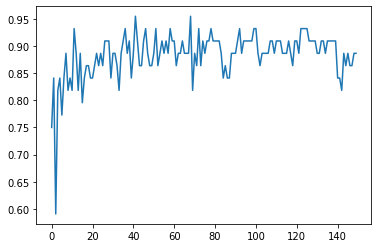

In [32]:
plt.plot(history.history['val_accuracy'])

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
y_pred = model.predict(X_test)

In [20]:
y_pred[1]

array([8.505179e-10, 3.764524e-06, 9.999962e-01], dtype=float32)

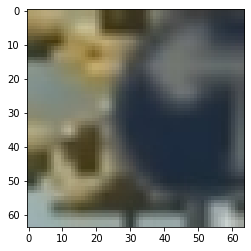

In [21]:
plt.imshow(X_test[1])

In [34]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.96      0.96      0.96        23
           2       0.85      1.00      0.92        17

    accuracy                           0.91        44
   macro avg       0.94      0.74      0.76        44
weighted avg       0.92      0.91      0.89        44



In [35]:
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

array([[ 1,  1,  2],
       [ 0, 22,  1],
       [ 0,  0, 17]])

In [38]:
with open('./Saved Models/Model/Sign.json', 'w') as model_file:
    model_file.write(model.to_json())

In [36]:
model.save('./Saved Models/Weights/sign.h5')